### Exploring Cape Python Policy with Pandas and Cape Core

This Jupyter Notebook is accompanied by our [Medium Post on Getting Started with Cape Core](https://medium.com/dropoutlabs/cape-core-privacy-and-data-science-working-together-d25a55526506). To follow along, you will need to [download the example dataset](https://capeprivacy.com/example-dataset/) and put it in a relative folder called `data` (or update the file path below). You will also need to [download the policy file](https://github.com/capeprivacy/cape-python/blob/master/examples/policy/iot_example_policy.yaml) and put it in a relative folder called `policy` or ensure you have Cape Python installed locally and change the path to use the copy in the `examples` folder.

You will also need a local (or deployed version) of Cape running and have generated an API token to follow along.

In [1]:
import pandas as pd
import cape_privacy as cape

%matplotlib inline

In [2]:
df = pd.read_csv('../data/iot_example.csv')

In [3]:
df.head()

,timestamp,username,temperature,heartrate,build,latest,note
0,2017-01-01T12:00:23,michaelsmith,12,67,4e6a7805-8faa-2768-6ef6-eb3198b483ac,0,interval
1,2017-01-01T12:01:09,kharrison,6,78,7256b7b0-e502-f576-62ec-ed73533c9c84,0,wake
2,2017-01-01T12:01:34,smithadam,5,89,9226c94b-bb4b-a6c8-8e02-cb42b53e9c90,0,NaN
3,2017-01-01T12:02:09,eddierodriguez,28,76,2599ac79-e5e0-5117-b8e1-57e5ced036f7,0,update
4,2017-01-01T12:02:36,kenneth94,29,62,122f1c6a-403c-2221-6ed1-b5caa08f11e0,0,user


In [4]:
df.dtypes

timestamp      object
username       object
temperature     int64
heartrate       int64
build          object
latest          int64
note           object
dtype: object

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

<AxesSubplot:>

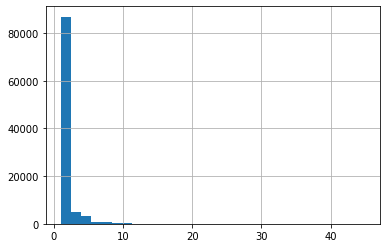

In [6]:
df.username.value_counts().hist(bins=30)

### Privacy Concerns

In this dataset which has mock data from wearable devices, we are concerned about the privacy of the individuals. It is a timeseries-based analysis, so we'd like to ensure we retain the ability to see the data of an individual change over time, but we want to provide some basic privacy protections for our exploratory data analysis and later model development activities.

The following policy file provides these protections:

- [Tokenization](https://docs.capeprivacy.com/libraries/cape-python/transformations/#tokenizer) of the username column with a maximum token length of 10 and a key defined in the file.
- [Date Truncation](https://docs.capeprivacy.com/libraries/cape-python/transformations/#date-truncation) for the timestamp column - removing the minutes and seconds of the data but keeping the year, month, date and hour.
- [Redaction](https://docs.capeprivacy.com/libraries/cape-python/redactions/) of the build column, which reveals information about the device it was built on. In Cape, redaction involves dropping of the matching data so this will change the shape of your dataframes.

In [7]:
!cat ../policy/iot_example_policy.yaml

label: iot_examplew_policy
version: 1
rules:
  - match:
      name: username
    actions:
      - transform:
          type: "tokenizer"
          max_token_len: 10
          key: "Please change this :)"
  - match:
      name: timestamp
    actions:
      - transform:
          type: "date-truncation"
          frequency: "hour"
  - match:
      name: build
    actions:
      - transform:
          type: "column-redact"
          columns: ["build"] 


### With Cape Core

If you are using Cape Core and have a project setup and registered with the above policy as well as an API token, you can use the following code to download the policy from the Cape Coordinator.

In [8]:
c = cape.Client("http://localhost:8080")
c.login("INSERT YOUR TOKEN HERE")
policy = c.get_policy("first-project")

### Apply the parsed policy

To apply the parsed policy, call the `apply_policy` function to your dataframe and sample the results.

In [9]:
caped_df = cape.apply_policy(policy, df)

In [11]:
caped_df.head()

,timestamp,username,temperature,heartrate,latest,note
0,2017-01-01 12:00:00,031a117699,12,67,0,interval
1,2017-01-01 12:00:00,4a6305ec73,6,78,0,wake
2,2017-01-01 12:00:00,7b18c69b6f,5,89,0,NaN
3,2017-01-01 12:00:00,3540599a15,28,76,0,update
4,2017-01-01 12:00:00,1652838cc5,29,62,0,user


### Now it's time to save this dataset and share for larger data science tasks

In [10]:
df.to_csv('../data/caped_iot_example.csv')